# Detector Class

In [19]:
import tensorflow as tf
import numpy as np
import cv2
import os
import traceback
import json

INPUT_DIMENSION = 227
BATCH_SIZE = 256


def write_json(name, data):
    filename = f'{name}.json'
    with open(filename, 'w') as outfile:
        json.dump(data, outfile)

class PredictJob():
    model = tf.keras.models.load_model(
        os.path.abspath('./CNN.model'), compile=True)

    def __init__(self, npimg, window_size):
        self.original_img = npimg
        self.window_size = window_size
        self.predictions_made = 0
        super().__init__()

    def run(self):
        num_rows = int(
            (self.original_img.shape[0] * 2) // self.window_size - 1)
        num_columns = int(
            (self.original_img.shape[1] * 2) // self.window_size - 1)

        self.predictions_to_make = num_rows * num_columns

        kernel_width = (self.original_img.shape[1] / (num_columns + 1)) * 2
        kernel_height = (self.original_img.shape[0] / (num_rows + 1)) * 2

        predictions = []
        batch = []

        try:
            # traverse image regions and make predictions in batches
            for j in range(num_rows):
                for i in range(num_columns):
                    new_slice = self.original_img[int(j*kernel_height/2): int(kernel_width + j*kernel_height/2),
                                                  int(i*kernel_width/2): int(kernel_width + i*kernel_width/2), :]
                    batch.append(new_slice)
                    if (len(batch) == BATCH_SIZE or (i == num_columns - 1 and j == num_rows - 1)):
                        self.predictions_made += len(batch)
                        predictions += (self.__predict_batch(batch))
                        batch = []
                        
                        print(f'progress: {self.predictions_made * 100 // self.predictions_to_make}%')

            result = {"num_rows": num_rows,
                      "num_cols": num_columns, "predictions": predictions}

            # All done! write json file with results
            # write_json('results', result)
            print('Job done!')
            return result

        except Exception as e:
            traceback.print_exc()
            # Something went wrong... write error to json file

    def __predict_batch(self, batch):
        # resize and normalize batch
        for i, img_arr in enumerate(batch):
            batch[i] = cv2.resize(
                img_arr, (INPUT_DIMENSION, INPUT_DIMENSION), interpolation=cv2.INTER_LINEAR)
        batch = np.array(batch)
        batch = batch / 255
        predictions_arr = self.model.predict(batch)
        predictions_list = [1 if pred[1] > 0.95 else 0 for pred in predictions_arr]
        return predictions_list

## Plot function

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

def get_prediction(row, col, predictions, num_columns):
    index = row * num_columns + col
    return predictions[index] == 1

def plot_results(img_path, result):
    predictions = result['predictions']
    num_rows = result['num_rows']
    num_columns = result['num_cols']
    # Create figure and axes
    _, ax = plt.subplots(figsize=(20, 10))
    # Display the image
    im = np.array(Image.open(img_path))
    print('imageshape: ', im.shape)
    ax.imshow(im)
    imgheight, imgwidth, _ = im.shape
    STRIDE_WIDTH = imgwidth / (num_columns + 1)
    STRIDE_HEIGHT = imgheight / (num_rows + 1)
    print(STRIDE_WIDTH)
    print(STRIDE_HEIGHT)

    # j = row index
    for j in range(num_rows):
        # i = column index
        for i in range(num_columns):
            if (get_prediction(j, i, predictions, num_columns)):
                # Create a Rectangle patch
                rect = patches.Rectangle((i * STRIDE_WIDTH, j * STRIDE_HEIGHT, ),
                                         STRIDE_WIDTH * 2, STRIDE_HEIGHT * 2, linewidth=1, edgecolor='r', facecolor='none')
                # Add the patch to the Axes
                ax.add_patch(rect) 
    plt.show()

## Usage

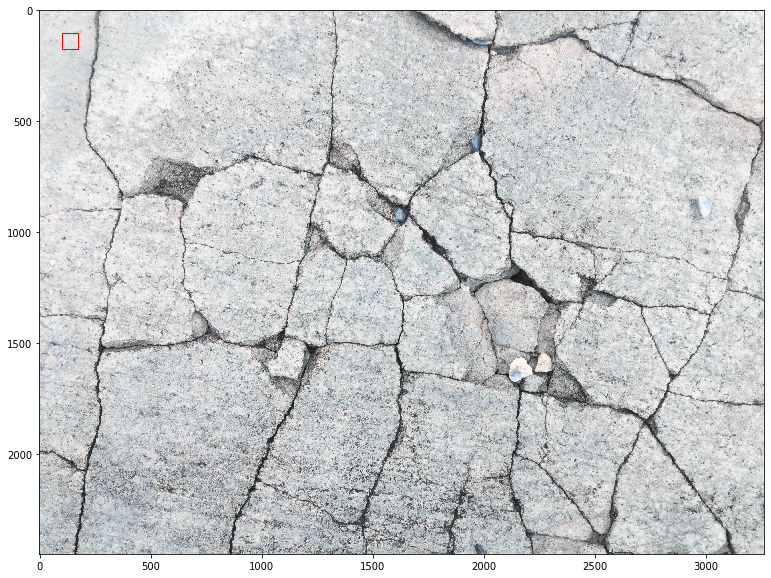

In [3]:
# set window size and image path
WINDOW_SIZE = 75
IMG_PATH = 'crack.jpg'

def showWindowPreview():
    _, ax = plt.subplots(figsize=(20, 10))
    original_img = cv2.imread(IMG_PATH, cv2.IMREAD_UNCHANGED)
    ax.imshow(original_img)
    rect = patches.Rectangle((100, 100), WINDOW_SIZE, WINDOW_SIZE, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.show()
    
showWindowPreview()

In [20]:
original_img = cv2.imread(IMG_PATH, cv2.IMREAD_UNCHANGED)
predictor = PredictJob(original_img, WINDOW_SIZE)
result = predictor.run()

progress: 4%
progress: 9%
progress: 13%
progress: 18%
progress: 23%
progress: 27%
progress: 32%
progress: 37%
progress: 41%
progress: 46%
progress: 51%
progress: 55%
progress: 60%
progress: 65%
progress: 69%
progress: 74%
progress: 79%
progress: 83%
progress: 88%
progress: 93%
progress: 97%
progress: 100%
Job done!


In [17]:
pred_sum = 0
pred_count = 0
for pred in result['predictions']:
    if pred < 0.5:
        pred_sum += pred
        pred_count += 1
print(pred_sum / pred_count)

0.029078211826386015


imageshape:  (2448, 3264, 3)
37.51724137931034
37.66153846153846


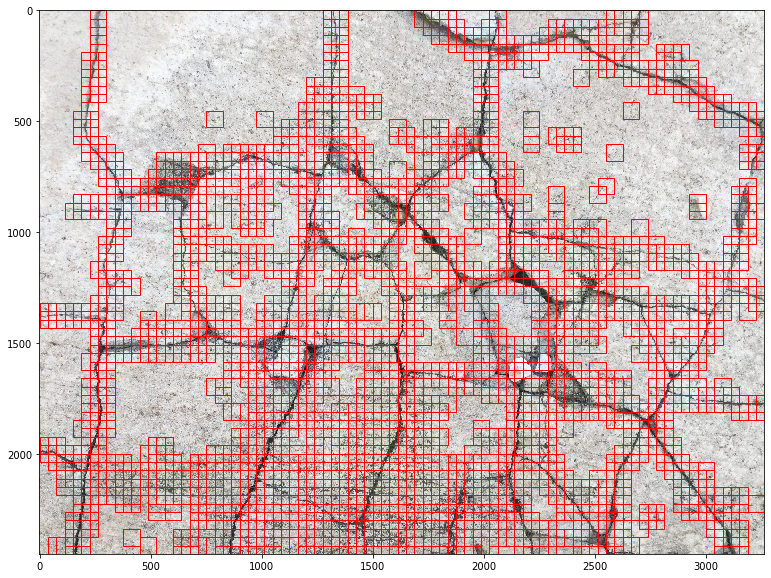

In [22]:
plot_results(IMG_PATH, result)

## Save Json

In [ ]:
import json

with open('results.json', 'w') as json_file:
    json.dump(result, json_file)